# Train and evaluate a 3D Convolutional Neural Network (3dCNN) to classify the entire HCP task catalogue

<p style='text-align: justify;'>In this notebook we create and train a 3D-Convolutional Neural Network which learns to classify different patterns of whole-brain fMRI statistical parameters (t-scores). In this first approach our goal is to train a classifier that can reliably distinguish between such whole-brain patterns for five limb movements (i.e., left/right hand, left/right foot, and tongue).

</p>

In [1]:
import os
import sys
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)

In [2]:
import os, wandb, torch, time
import pandas as pd
import numpy as np
from glob import glob
from torch.utils.data import DataLoader
from torchinfo import summary
import seaborn as sns
import matplotlib.pyplot as plt

from delphi import mni_template
from delphi.networks.ConvNets import BrainStateClassifier3d
from delphi.utils.datasets import NiftiDataset
from delphi.utils.tools import ToTensor, compute_accuracy, convert_wandb_config, read_config, z_transform_volume
from delphi.utils.plots import confusion_matrix

from sklearn.model_selection import StratifiedShuffleSplit

# you can find all these files in ../utils
from utils.tools import attribute_with_method, concat_stat_files, compute_mi
from utils.wandb_funcs import reset_wandb_env, wandb_plots
from utils.random import set_random_seed

from tqdm.notebook import tqdm

DEVICE = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

<frozen importlib._bootstrap>:219: RuntimeWarning: scipy._lib.messagestream.MessageStream size changed, may indicate binary incompatibility. Expected 56 from C header, got 64 from PyObject


<p style='text-align: justify;'>To make sure that we obtain (almost) the same results for each execution we set the random seed of multiple different librabries (i.e., torch, random, numpy)</p>

In [3]:
g = set_random_seed(2020) # the project started in the year 2020, hence the seed

## Initializations

In this section, we define and initialize our required variables. We first need to define which classes we want to predict, i.e., the conditions of the motor mapper. We then define a PyTorch dataset; in this case `NiftiDataset` is a custom written Dataset-Class (see https://github.com/PhilippS893/delphi). As is common practice in machine learning projects, we split our data into a training and validation dataset (ratio=80 to 20, respectively).

Note: In case it is necessary to create a null-model, i.e., a neural network that is trained on data where the labels are randomized, one can set the parameter `shuffe_labels=False` to `True`. This is usually done to have a baseline for the null hypothesis that "everything is random".

In [4]:
class_labels = ["footleft", "footright", "handleft", "handright", "tongue", 
                "loss", "reward", 
                "mental", "random", 
                "body", "face", "place", "tool", 
                "match", "relation", 
                "emotion", "neut", 
                "story", "math"]
data_test = NiftiDataset("../t-maps/test", class_labels, 0, device=DEVICE, transform=ToTensor())

# Identify the best fold

In [5]:
from utils.wandb_funcs import get_wandb_csv

In [6]:
keys_of_interest = ['group', 'job_type', 'run_name', 'test_accuracy', 'train_acc', 'valid_acc', 
                    'valid_loss', 'best_valid_epoch', 'best_valid_accuracy', 'test_loss', 'train_loss']
wandb_df = get_wandb_csv("philis893", "thesis", "full-hcp", keys_of_interest, job_name="CV-7folds-real", overwrite=True)

real_runs = wandb_df[wandb_df.job_type == "CV-7folds-real"]
# sort according to best_valid_accuracy (desc), test_accuracy (desc), and test_loss (asc). Take the first entry => best fold
real_runs_sorted = real_runs.sort_values(["best_valid_accuracy", "test_accuracy", "test_loss"], ascending=[False, False, True])
real_runs_sorted.head(1)

{'entity': 'philis893', 'project': 'thesis', 'filters': {'group_name': {'$regex': 'full-hcp.*'}, 'jobType': 'CV-7folds-real'}, 'order': '-created_at', '_sweeps': {}, 'client': <wandb.apis.public.RetryingClient object at 0x7f231c3a9dc0>, 'variables': {'project': 'thesis', 'entity': 'philis893', 'order': '-created_at', 'filters': '{"group_name": {"$regex": "full-hcp.*"}, "jobType": "CV-7folds-real"}'}, 'per_page': 50, 'objects': [], 'index': -1, 'last_response': None}


,group,job_type,run_name,test_accuracy,train_acc,valid_acc,valid_loss,best_valid_epoch,best_valid_accuracy,test_loss,train_loss
5,full-hcp,CV-7folds-real,seed-2020_fold-01,0.876316,0.924561,0.860526,0.334964,50,0.902632,0.354409,0.181635


In [7]:
BEST_FOLD = 1;

# SecondLevel GLM analyses

We need some way to compare the attribution maps from LRP and GBP to the original t-maps. To do this, we first compute a group level analysis across the subjects in the left-out test dataset.
That is, we compute a group level 
* t-map, 
* LRP-map, and 
* GBP-map.

In a later stage we can then use, for example, mutual information to quantify the similarity in a whithin subject and subject-vs-grpmap fashion. 
With such comparisons we can check whether mutual information of LRP/GBP maps with their respective group map is larger than, e.g., the mutual information between single subjects' t-maps (i.e., the original input data) with their respective group map.

We therefore will perform the following comparisons:

* subattr vs grpattr (grp attr is a map computed by leaving the subject out of the GLM whos map we want to compare to the grp, e.g., leave-out subject-01 in computing the grp map but use its attribution map to compute mutual information)
* subt vs grpt (same as above)
* subattr vs subt
* grpattr vs grpt

In [8]:
import matplotlib.pyplot as plt
import nilearn
from nilearn.image import load_img
from nilearn.glm.second_level import SecondLevelModel
import nibabel as nib

def save_stat_maps(data, prefix, save_loc='stat-maps', maps_of_interest=["z_score"]):
    
    if not os.path.exists(save_loc):
        os.makedirs(save_loc)
    
    for i, key in enumerate(maps_of_interest):
        path2save = os.path.join(save_loc, f"{prefix}_{key}.nii.gz")
        nib.save(data[key], path2save)

/home/philippseidel/anaconda3/envs/thesis-env/lib/python3.8/site-packages/nilearn/glm/__init__.py:55: FutureWarning: The nilearn.glm module is experimental. It may change in any future release of Nilearn.
  warn('The nilearn.glm module is experimental. '


In [9]:
# load the real images
test_img_files = []
[test_img_files.extend(sorted(glob(f"../copes/test/{class_labels[i]}/*.nii.gz"))) for i in range(len(class_labels))]
images = load_img(test_img_files)
n_subs = 20
# assign the correct labels to each file
real = np.repeat(np.arange(len(class_labels)), n_subs)

# a whole brain mask
mask = load_img(mni_template)

In this group level analysis we are interested in computing the average t-map for each condition: footleft, footright, handleft, handright, and tongue. 
Just due to curiousity we will also compute an average t-map across all conditions.

The code cell below produces and plots the design matrix for our GLM analysis.

The data and matrix are setup in a way that the all files of the same condition are grouped together, hence we can see 20 '1's for each condition (first 5 columns). The "average" contrast simply contains "1"s for all input volumes.
As this is a paired design we need to assign the subjects to their respective volumes. You can see this by the sub-XX columns.

/home/philippseidel/anaconda3/envs/thesis-env/lib/python3.8/site-packages/nilearn/datasets/__init__.py:87: FutureWarning: Fetchers from the nilearn.datasets module will be updated in version 0.9 to return python strings instead of bytes and Pandas dataframes instead of Numpy arrays.
  warn("Fetchers from the nilearn.datasets module will be "


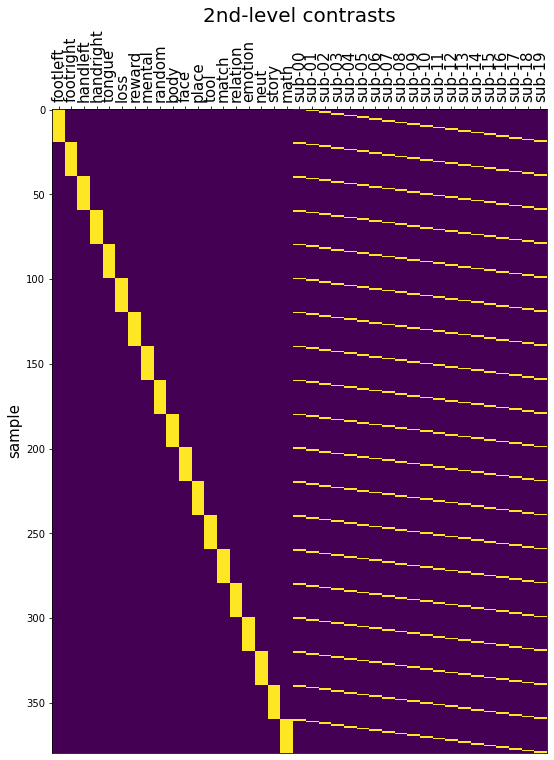

In [10]:
# set up the 2nd-level contrast matrix
from nilearn.plotting import plot_design_matrix, plot_contrast_matrix
n = len(test_img_files)
design_matrix = {}

for label in range(len(class_labels)):
    regressor = np.repeat(np.eye(len(class_labels))[label], n_subs)
    design_matrix[f'{class_labels[label]}'] = regressor

for sub in range(n_subs):
    regressor = np.tile(np.eye(n_subs)[sub], len(class_labels))
    design_matrix[f'sub-{sub:02d}'] = regressor

df_design_matrix = pd.DataFrame(design_matrix)
fig, ax = plt.subplots(figsize=(8, 10))
plot_design_matrix(df_design_matrix, rescale=False, ax=ax);
ax.set_xticklabels(df_design_matrix.columns, fontsize=15, rotation=90, ha="center");
ax.set_ylabel("sample", fontsize=15);
ax.xaxis.set_label_position('top') 
ax.set_title("2nd-level contrasts", fontsize=20);

#plt.savefig('figures/2nd-level-matrix-nilearn.pdf', facecolor=fig.get_facecolor(), transparent=True)

In [11]:
# create the glm
glm = SecondLevelModel(smoothing_fwhm=3, mask_img=mask)

In [12]:
# perform the GLM once on the original beta maps
glm.fit([nilearn.image.index_img(images, i) for i in range(n)], design_matrix=df_design_matrix)

contrasts = class_labels

for c, contrast in tqdm(enumerate(contrasts), desc="contrast"):
    maps_orig = glm.compute_contrast(contrast, output_type="all")
    save_stat_maps(maps_orig, f"{contrast}", save_loc="stat-maps/orig/SS3")

contrast: 0it [00:00, ?it/s]

/home/philippseidel/anaconda3/envs/thesis-env/lib/python3.8/site-packages/nilearn/_utils/glm.py:335: RuntimeWarning: divide by zero encountered in true_divide
  return np.where(X <= 0, 0, 1. / X)


In [13]:
# perform the GLM on the relevance maps for each individual fold
# load the relevance images
contrasts = class_labels
attr_types = ["lrp", "guidedbackprop"] #"lrp" "guidedbackprop"
label_orders = ["real"]#, "shuffled"] #, "real", "shuffled"

overwrite = True

fold = BEST_FOLD

for a, attr_type in enumerate(attr_types):

    for l, label_order in enumerate(label_orders):
        print(attr_type, label_order, fold)

        save_loc = os.path.join("stat-maps", attr_type, label_order, f"fold-{fold:02d}", "SS3")

        if not os.path.isdir(save_loc) or overwrite:

            relevance_files = glob(os.path.join(attr_type, label_order, f"fold-{fold:02d}/*.nii.gz"))
            relevance_maps = load_img(relevance_files)

            # set up the GLM for the current fold
            glm.fit([nilearn.image.index_img(relevance_maps , i) for i in range(n)], design_matrix=df_design_matrix)

            for c, contrast in enumerate(contrasts):
                maps_attr = glm.compute_contrast(contrast, output_type="all")
                save_stat_maps(maps_attr, f"{contrast}", save_loc=save_loc)


lrp real 1
guidedbackprop real 1


## Leave-one-subject-out grp maps

Now that we have the group LRP, GBP, and t-maps, we can turn to the leave-one-subject-out tests. We need these group statistics as well to be unbiased in computing the sub(attr/t) vs group(attr/t) mutual information. 

In [14]:
# compute a GLM for the test data set by leaving 1-subject out. We will need this for the mutual information analysis later
contrasts = class_labels

sub_list = np.tile(np.arange(n_subs), len(class_labels))

for s in tqdm(range(n_subs), desc="sub"):
    
    # copy the original design matrix
    this_dm = df_design_matrix.copy()
    
    # now drop the respective subject
    this_dm = this_dm.drop(labels=np.squeeze(np.where(sub_list == s)), axis="index")
    this_dm = this_dm.drop(columns=[f"sub-{s:02d}"])
    #plot_design_matrix(this_dm)
    
    idcs = np.arange(n)
    idcs = np.delete(idcs, np.where(sub_list == s))
    
    # perform the GLM on the all subs except s
    glm.fit([nilearn.image.index_img(images, i) for i in idcs], design_matrix=this_dm)

    for c, contrast in enumerate(contrasts):
        maps_orig = glm.compute_contrast(contrast, output_type="all")
        save_stat_maps(maps_orig, f"{contrast}_wo-sub{s:02d}", save_loc="stat-maps/orig/SS3/left-out", maps_of_interest=["z_score"])

sub:   0%|          | 0/20 [00:00<?, ?it/s]

/home/philippseidel/anaconda3/envs/thesis-env/lib/python3.8/site-packages/nilearn/_utils/glm.py:335: RuntimeWarning: divide by zero encountered in true_divide
  return np.where(X <= 0, 0, 1. / X)
/home/philippseidel/anaconda3/envs/thesis-env/lib/python3.8/site-packages/nilearn/_utils/glm.py:335: RuntimeWarning: divide by zero encountered in true_divide
  return np.where(X <= 0, 0, 1. / X)
/home/philippseidel/anaconda3/envs/thesis-env/lib/python3.8/site-packages/nilearn/_utils/glm.py:335: RuntimeWarning: divide by zero encountered in true_divide
  return np.where(X <= 0, 0, 1. / X)
/home/philippseidel/anaconda3/envs/thesis-env/lib/python3.8/site-packages/nilearn/_utils/glm.py:335: RuntimeWarning: divide by zero encountered in true_divide
  return np.where(X <= 0, 0, 1. / X)
/home/philippseidel/anaconda3/envs/thesis-env/lib/python3.8/site-packages/nilearn/_utils/glm.py:335: RuntimeWarning: divide by zero encountered in true_divide
  return np.where(X <= 0, 0, 1. / X)
/home/philippseidel/

In [15]:
# COMPUTE THE GLM FOR EACH FOLD BUT LEAVE OUT ONE SUBJECT AT A TIME
# perform the GLM on the relevance maps for each individual fold
# load the relevance images
contrasts = class_labels
attr_types = ["lrp", "guidedbackprop"] #"lrp" "guidedbackprop"
label_orders = ["real"] #, "shuffled"] #, "real", "shuffled"

overwrite = True

fold = BEST_FOLD

sub_list = np.tile(np.arange(n_subs), len(class_labels))

for a, attr_type in enumerate(attr_types):
    
    for l, label_order in enumerate(label_orders):
        print(attr_type, label_order)

        save_loc = os.path.join("stat-maps", attr_type, label_order, f"fold-{fold:02d}", "SS3", "left-out")

        if not os.path.isdir(save_loc) or overwrite:

            # load the files for a given fold
            relevance_files = glob(os.path.join(attr_type, label_order, f"fold-{fold:02d}/*.nii.gz"))
            relevance_maps = load_img(relevance_files)

            for s in tqdm(range(n_subs), leave=False, desc="subs"):

                # copy the original design matrix
                this_dm = df_design_matrix.copy()

                # now drop subject s from the design matrix
                this_dm = this_dm.drop(labels=np.squeeze(np.where(sub_list == s)), axis="index")
                this_dm = this_dm.drop(columns=[f"sub-{s:02d}"])

                # remove the subject s' indices from the data list
                idcs = np.arange(n)
                idcs = np.delete(idcs, np.where(sub_list == s))

                # perform the GLM on the all subs except s
                glm.fit([nilearn.image.index_img(relevance_maps, i) for i in idcs], design_matrix=this_dm)

                for c, contrast in enumerate(contrasts):
                    maps_orig = glm.compute_contrast(contrast, output_type="all")
                    save_stat_maps(maps_orig, f"{contrast}_wo-sub{s:02d}", save_loc=save_loc, maps_of_interest=["z_score"])

lrp real


subs:   0%|          | 0/20 [00:00<?, ?it/s]

guidedbackprop real


subs:   0%|          | 0/20 [00:00<?, ?it/s]